In [49]:
from keras.preprocessing.image import load_img,img_to_array
import numpy  as np
from keras.applications import vgg19
import matplotlib.pyplot as plt
%matplotlib inline

content_img_path='IMG_1817.JPG'
style_img_path='305130.jpg'


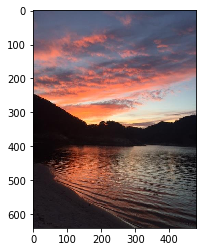

In [50]:
img=load_img(content_img_path)
plt.imshow(img)


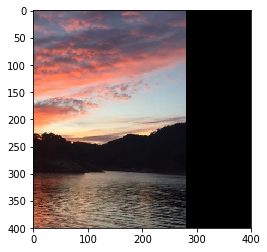

In [51]:
img=img.crop((200,100,600,500))
plt.imshow(img)

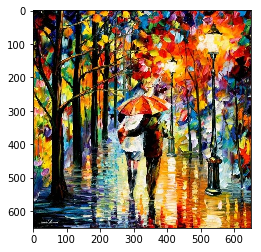

In [52]:
img=load_img(style_img_path)
plt.imshow(img)

In [53]:
def preprocess_img(img_path):
    
    img=load_img(img_path)
    width,height=img.size
    
    im_height_n=400

    im_width_n=int(width*im_height_n/height)
    desired_width, desired_height = 400, 400
    
    img = img.resize((im_width_n, im_height_n))
    #img=img_to_array(img)
    #img = array_to_img(img, scale=False)
    #plt.imshow(img)
    #plt.show()
    if im_width_n < desired_width:
        desired_width = im_width_n
    start_x = np.maximum(0, int(im_width_n-desired_width)/2)
    start_y= np.maximum(0, int(im_height_n-desired_height)/2)

    img = img.crop((start_x, start_y, start_x+desired_width, start_y+desired_height))
    #plt.imshow(img)
    #plt.show()
    img = img.resize((400, 400))
    plt.imshow(img)
    plt.show()

    img = img_to_array(img)
    
    print(img.size)
    img=np.expand_dims(img,axis=0)  #add one dimension to get 1,width,height for batch size
    img=vgg19.preprocess_input(img)
    return img


# mode: One of "caffe", "tf". - caffe: will convert the images from RGB to BGR, then will zero-center each color channel
# with respect to the ImageNet dataset, without scaling. - tf: will scale pixels between -1 and 1, sample-wise.

In [54]:
def unprocess_img(img):
    #mean = [103.939, 116.779, 123.68]
    
    img[:,:,0] +=103.939
    img[:,:,1] +=116.779
    img[:,:,2] +=123.68
    
    # convert back from RGB to BGR
    img=img[:,:,::-1]
    img=np.clip(img,0,255).astype('uint8')
    return img


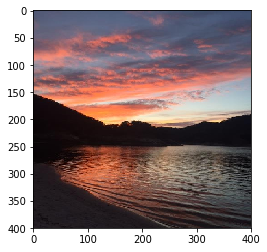

480000


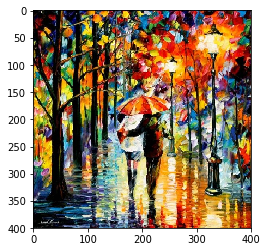

480000


In [55]:
from keras import backend as K

content_image=K.constant(preprocess_img(content_img_path))
style_image=K.constant(preprocess_img(style_img_path))

(im_height,im_width)=(400,400)
generated_image=K.placeholder((1,im_height,im_width,3),name='generate_placeholder')  # 1*400*400*3


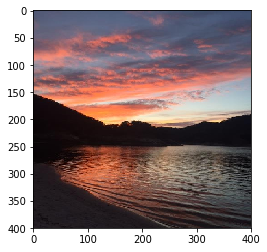

480000


160000

In [56]:
a=preprocess_img(content_img_path)
a[0,:,:,0].size #400*400

In [57]:
input_tensor=K.concatenate([content_image,style_image,generated_image],axis=0)


In [58]:
model=vgg19.VGG19(input_tensor=input_tensor,include_top=False,weights='imagenet')

In [59]:
def content_loss(content,generate):
    
    return K.sum(K.square(content-generate))

In [60]:
def style_loss(style,generate):
    
    S_gram=gram_matrix(style)
    G_gram=gram_matrix(generate)
    
    channel=3
    size=im_height*im_width
    
    return K.sum(K.square(S_gram-G_gram))/(4.0*(channel**2.0)*(size**2.0))   #normalize to input

In [61]:
def gram_matrix(input_matrix):
    
    feature=K.batch_flatten(K.permute_dimensions(input_matrix,(2,0,1)))  #dictate order of dimension to be transposed 
    return K.dot(feature,K.transpose(feature))
    

In [62]:
def variation_loss(generate):  #0:<399  (0<=388) - 1:<400 (1<=399) substract x and y direction separately from iteself 
                            # with a shift to remove blurr, and sharp pixel, per batch and color channel
    
    a=K.square(generate[:,:im_height-1,:im_width-1,:]-generate[:,1:,:im_width-1,:])
    b=K.square(generate[:,:im_height-1,:im_width-1,:]-generate[:,:im_height-1,1:,:])
    
    return K.sum(K.pow(a+b,1.25))

In [63]:
output_dict=  dict([(layer.name,layer.output)  for layer in model.layers])

In [64]:
print(output_dict)

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 400, 400, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 200, 200, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 100, 100, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4_2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block

In [65]:
content_layer='block5_conv2'
style_layer=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

In [66]:
variation_weight=0.0001
style_weight=1.0
content_weight=0.025

In [67]:
# loss update

loss=K.variable(0.0)

content_layer_feature=output_dict[content_layer]  #input of a network has three photo content_image,style_image,generated_image

content_feature=content_layer_feature[0,:,:,:] # content * width * height *filter
generate_feature=content_layer_feature[2,:,:,:] #generate * width * height *filter
loss += content_weight*content_loss(content_feature,generate_feature)   

for layer in style_layer:
    
    style_layer_feature=output_dict[layer]
    
    style_feature=style_layer_feature[1,:,:,:]
    generate_feature=style_layer_feature[2,:,:,:]
    
    
    loss +=style_weight*(style_loss(style_feature,generate_feature))/len(style_layer)
    
       
loss += variation_weight*variation_loss(generated_image) # this is not from network output but network input    


In [68]:
# create connections grad, input , loss

grads=K.gradients(loss,generated_image)[0]  #gradient respect to genertaae image
function_loss_grad=K.function([generated_image],[loss,grads])

In [69]:

class loss_grad_separate(object):
    
    def __init__(self):
        
        self.loss_value=None
        self.grad_value=None
        
    def loss(self,x):
        
        assert self.loss_value is None
        
        x=x.reshape((1,im_height,im_width,3)) #reshpae generate image
        out=function_loss_grad([x])
        loss_value=out[0]
        grad_value=out[1].flatten().astype('float64')
        
        self.loss_value=loss_value
        self.grad_value=grad_value
        
        return self.loss_value
    
    
    def grad(self,x):
        
        assert self.loss_value is not None
        grad_value=np.copy(self.grad_value)
        
        self.loss_value=None
        self.grad_value=None
        
        return grad_value
        


In [70]:
loss_grad_separator=loss_grad_separate()

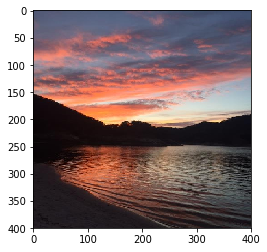

480000
start iteration: 0
current loss 8.2251e+09
Image saved as my_result_at_iteration_0.png
Iteration 0 completed in 9s
start iteration: 1


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


current loss 2.75257e+09
Image saved as my_result_at_iteration_1.png
Iteration 1 completed in 8s
start iteration: 2
current loss 1.58292e+09
Image saved as my_result_at_iteration_2.png
Iteration 2 completed in 8s
start iteration: 3
current loss 1.12625e+09
Image saved as my_result_at_iteration_3.png
Iteration 3 completed in 8s
start iteration: 4
current loss 8.58502e+08
Image saved as my_result_at_iteration_4.png
Iteration 4 completed in 8s
start iteration: 5
current loss 6.98844e+08
Image saved as my_result_at_iteration_5.png
Iteration 5 completed in 8s
start iteration: 6
current loss 6.09246e+08
Image saved as my_result_at_iteration_6.png
Iteration 6 completed in 8s
start iteration: 7
current loss 5.42912e+08
Image saved as my_result_at_iteration_7.png
Iteration 7 completed in 8s
start iteration: 8
current loss 4.76602e+08
Image saved as my_result_at_iteration_8.png
Iteration 8 completed in 8s
start iteration: 9
current loss 4.24187e+08
Image saved as my_result_at_iteration_9.png
Ite

In [71]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix='my_result'
iteration=20

x=preprocess_img(content_img_path) #start from content
x=x.flatten()

for i in range(iteration):
    
    print('start iteration:',i)
    start_time=time.time()
    
    x,min_val,info=fmin_l_bfgs_b(loss_grad_separator.loss,x,fprime=loss_grad_separator.grad,maxfun=20)
    
    print('current loss', min_val)
    
    img=x.copy().reshape((im_height,im_width,3))
    
    img=unprocess_img(img)
    
    fname=result_prefix+'_at_iteration_%d.png' % i
    imsave(fname,img)
    print('Image saved as', fname)
    end_time=time.time()
    print('Iteration %d completed in %ds' % (i,end_time-start_time))

